**LOADING LIBRARIES**

In [128]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# For model building
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split

# For evaluation
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder


****LOADING DATA****

In [130]:
# Load data
df = pd.read_csv("C:\\Users\\user\\Downloads\\student_performance_dataset.csv")  

# Preview the data
df.head()

,Student_ID,Gender,Study_Hours_per_Week,Attendance_Rate,Past_Exam_Scores,Parental_Education_Level,Internet_Access_at_Home,Extracurricular_Activities,Final_Exam_Score,Pass_Fail
0,S147,Male,31,68.267841,86,High School,Yes,Yes,63,Pass
1,S136,Male,16,78.222927,73,PhD,No,No,50,Fail
2,S209,Female,21,87.525096,74,PhD,Yes,No,55,Fail
3,S458,Female,27,92.076483,99,Bachelors,No,No,65,Pass
4,S078,Female,37,98.655517,63,Masters,No,Yes,70,Pass


**EXPLORATORY DATA ANALYSIS**

In [132]:
# Shape and basic info
print(f"Shape: {df.shape}")
df.info()

# Check for missing values
print("\nMissing values:\n", df.isnull().sum())

# Summary statistics
df.describe()

# Value counts of the target column 
print("\nPass_Fail")
print(df['Pass_Fail'].value_counts())


Shape: (708, 10)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 708 entries, 0 to 707
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Student_ID                  708 non-null    object 
 1   Gender                      708 non-null    object 
 2   Study_Hours_per_Week        708 non-null    int64  
 3   Attendance_Rate             708 non-null    float64
 4   Past_Exam_Scores            708 non-null    int64  
 5   Parental_Education_Level    708 non-null    object 
 6   Internet_Access_at_Home     708 non-null    object 
 7   Extracurricular_Activities  708 non-null    object 
 8   Final_Exam_Score            708 non-null    int64  
 9   Pass_Fail                   708 non-null    object 
dtypes: float64(1), int64(3), object(6)
memory usage: 55.4+ KB

Missing values:
 Student_ID                    0
Gender                        0
Study_Hours_per_Week          0
Attendance_Rate  

**LABEL ENCODING**


Encoded 'pass' label distribution:
pass
1    354
0    354
Name: count, dtype: int64


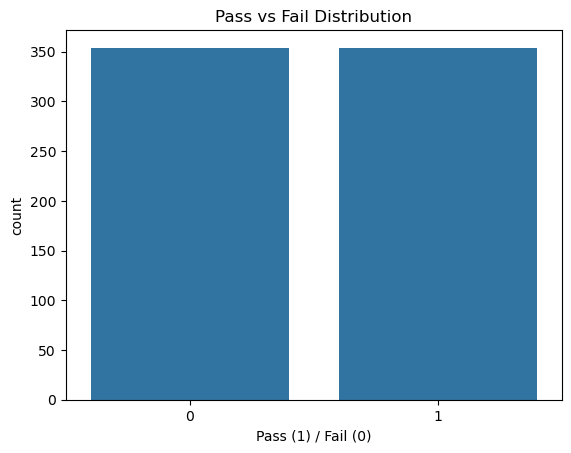

In [134]:
# Clean and convert 'Pass_Fail' to binary 1 (Pass) / 0 (Fail)
df['pass'] = df['Pass_Fail'].str.strip().str.lower().map({'pass': 1, 'fail': 0})

# Drop original 'Pass_Fail' column if it's no longer needed
df.drop(columns=['Pass_Fail'], inplace=True)

# Optional: Drop Student_ID if it's just an identifier
df.drop(columns=['Student_ID'], inplace=True)

# Confirm the distribution
print("\nEncoded 'pass' label distribution:")
print(df['pass'].value_counts())

# Visualize
sns.countplot(x='pass', data=df)
plt.title("Pass vs Fail Distribution")
plt.xlabel("Pass (1) / Fail (0)")
plt.show()


**Identifying categorical and numeric columns**

In [136]:
# Separating features and target
X = df.drop(columns=['pass'])  # features
y = df['pass']                 # target

# Identifying categorical and numeric columns
categorical_cols = X.select_dtypes(include='object').columns.tolist()
numeric_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

print("Categorical columns:", categorical_cols)
print("Numeric columns:", numeric_cols)


Categorical columns: ['Gender', 'Parental_Education_Level', 'Internet_Access_at_Home', 'Extracurricular_Activities']
Numeric columns: ['Study_Hours_per_Week', 'Attendance_Rate', 'Past_Exam_Scores', 'Final_Exam_Score']


**One-hot encode categoricals & scale numerics**

In [138]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Preprocessing pipeline
preprocessor = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols),
    ('num', StandardScaler(), numeric_cols)
])


**Train-test split**

In [140]:
from sklearn.model_selection import train_test_split

# 80% train, 20% test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

# Fit and transform
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)


**Converting to numpy arrays**

In [142]:
import numpy as np

# Converting to numpy arrays 
X_train_np = X_train_processed
X_test_np = X_test_processed

# Converting labels to numpy arrays
y_train_np = y_train.to_numpy()
y_test_np = y_test.to_numpy()

print("Train shape:", X_train_np.shape)
print("Test shape:", X_test_np.shape)


Train shape: (566, 14)
Test shape: (142, 14)


**Creating a PyTorch Dataset Class**

In [144]:
import torch
from torch.utils.data import Dataset

class StudentPerformanceDataset(Dataset):
    def __init__(self, features, labels):
        self.features = torch.tensor(features, dtype=torch.float32)  # Convert features to tensor
        self.labels = torch.tensor(labels, dtype=torch.long)         # Convert labels to tensor

    def __len__(self):
        # Return the number of samples in the dataset
        return len(self.features)

    def __getitem__(self, idx):
        # Return the feature and label at the given index
        return self.features[idx], self.labels[idx]


**Creating DataLoaders for Training and Testing**

In [146]:
from torch.utils.data import DataLoader

# Creating Dataset instances
train_dataset = StudentPerformanceDataset(X_train_np, y_train_np)
test_dataset = StudentPerformanceDataset(X_test_np, y_test_np)

# Creating DataLoader instances for batching and shuffling
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Check batch data
for batch_features, batch_labels in train_loader:
    print("Batch features shape:", batch_features.shape)
    print("Batch labels shape:", batch_labels.shape)
    break  # Just print the first batch to check


Batch features shape: torch.Size([32, 14])
Batch labels shape: torch.Size([32])


**Defining the Network in PyTorch**

In [77]:
import torch.nn as nn
import torch.optim as optim

# Define the Neural Network class
class StudentPerformanceModel(nn.Module):
    def __init__(self, input_dim):
        super(StudentPerformanceModel, self).__init__()
        self.layer1 = nn.Linear(input_dim, 64)  # First hidden layer (64 neurons)
        self.layer2 = nn.Linear(64, 32)         # Second hidden layer (32 neurons)
        self.output_layer = nn.Linear(32, 1)    # Output layer (1 neuron for binary classification)
        self.sigmoid = nn.Sigmoid()             # Sigmoid activation function for output

    def forward(self, x):
        x = torch.relu(self.layer1(x))  # Apply ReLU activation to layer 1
        x = torch.relu(self.layer2(x))  # Apply ReLU activation to layer 2
        x = self.sigmoid(self.output_layer(x))  # Apply Sigmoid activation to the output layer
        return x


**Set Up the Loss Function and Optimizer**

In [79]:
# Initialize the model
input_dim = X_train_np.shape[1]  # Number of input features
model = StudentPerformanceModel(input_dim)

# Loss function (binary cross-entropy)
criterion = nn.BCEWithLogitsLoss()

# Optimizer (Adam)
optimizer = optim.Adam(model.parameters(), lr=0.001)


**Training the Model with train data**

In [81]:
# Training loop
epochs = 20  # Number of epochs to train the model
for epoch in range(epochs):
    model.train()  # Set the model to training mode
    running_loss = 0.0
    correct_preds = 0
    total_preds = 0
    
    for batch_features, batch_labels in train_loader:
        # Move data to the device (if using GPU, otherwise stays on CPU)
        batch_features, batch_labels = batch_features, batch_labels.unsqueeze(1)  # Unsqueeze to match the output shape

        # Zero the gradients from the previous step
        optimizer.zero_grad()

        # Forward pass: Get predictions
        outputs = model(batch_features)

        # Calculate loss (binary cross-entropy)
        loss = criterion(outputs, batch_labels.float())

        # Backward pass: Compute gradients
        loss.backward()

        # Update the model parameters
        optimizer.step()

        # Track the loss and accuracy
        running_loss += loss.item()
        predicted = (outputs > 0.5).float()  # Convert probabilities to 0 or 1
        correct_preds += (predicted == batch_labels).sum().item()
        total_preds += batch_labels.size(0)

    # Calculate and print the average loss and accuracy for the epoch
    avg_loss = running_loss / len(train_loader)
    accuracy = correct_preds / total_preds
    print(f'Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}')


Epoch 1/20, Loss: 0.7216, Accuracy: 0.6519
Epoch 2/20, Loss: 0.6953, Accuracy: 0.8569
Epoch 3/20, Loss: 0.6517, Accuracy: 0.8710
Epoch 4/20, Loss: 0.5981, Accuracy: 0.9064
Epoch 5/20, Loss: 0.5615, Accuracy: 0.9240
Epoch 6/20, Loss: 0.5465, Accuracy: 0.9470
Epoch 7/20, Loss: 0.5383, Accuracy: 0.9470
Epoch 8/20, Loss: 0.5329, Accuracy: 0.9523
Epoch 9/20, Loss: 0.5289, Accuracy: 0.9611
Epoch 10/20, Loss: 0.5256, Accuracy: 0.9717
Epoch 11/20, Loss: 0.5210, Accuracy: 0.9788
Epoch 12/20, Loss: 0.5198, Accuracy: 0.9788
Epoch 13/20, Loss: 0.5181, Accuracy: 0.9788
Epoch 14/20, Loss: 0.5176, Accuracy: 0.9806
Epoch 15/20, Loss: 0.5151, Accuracy: 0.9894
Epoch 16/20, Loss: 0.5152, Accuracy: 0.9894
Epoch 17/20, Loss: 0.5128, Accuracy: 0.9965
Epoch 18/20, Loss: 0.5116, Accuracy: 0.9982
Epoch 19/20, Loss: 0.5110, Accuracy: 0.9965
Epoch 20/20, Loss: 0.5103, Accuracy: 0.9965


**Evaluating the Model**

In [83]:
# Evaluation loop
model.eval()  # Set the model to evaluation mode
correct_preds = 0
total_preds = 0

with torch.no_grad():  # Disable gradient calculation for evaluation
    for batch_features, batch_labels in test_loader:
        # Forward pass: Get predictions
        outputs = model(batch_features)

        # Convert probabilities to 0 or 1
        predicted = (outputs > 0.5).float()
        
        # Calculate accuracy
        correct_preds += (predicted == batch_labels.unsqueeze(1)).sum().item()
        total_preds += batch_labels.size(0)

accuracy = correct_preds / total_preds
print(f'Test Accuracy: {accuracy:.4f}')


Test Accuracy: 0.9789


**MODEL EVALUATION**

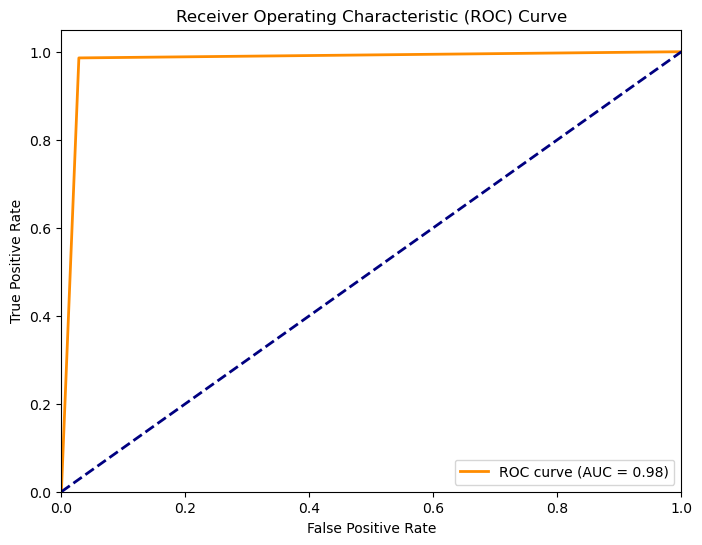

Accuracy: 0.9789
Precision: 0.9722
Recall: 0.9859
F1 Score: 0.9790
ROC AUC: 0.9789


In [85]:
# Evaluation function
def evaluate_model(model, test_loader):
    model.eval()  # Set the model to evaluation mode
    true_labels = []
    predictions = []

    with torch.no_grad():  # No need to calculate gradients for evaluation
        for batch_features, batch_labels in test_loader:
            outputs = model(batch_features)
            predicted = (outputs > 0.5).float()  # Convert to binary labels
            true_labels.extend(batch_labels.numpy())
            predictions.extend(predicted.numpy())

    # Convert lists to numpy arrays for metric calculation
    true_labels = np.array(true_labels)
    predictions = np.array(predictions)

    # Calculate accuracy, precision, recall, and F1 score
    accuracy = accuracy_score(true_labels, predictions)
    precision = precision_score(true_labels, predictions)
    recall = recall_score(true_labels, predictions)
    f1 = f1_score(true_labels, predictions)

    # Calculate ROC curve and AUC score
    fpr, tpr, _ = roc_curve(true_labels, predictions)
    roc_auc = auc(fpr, tpr)

    # Plot the ROC curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.show()

    # Print out the evaluation metrics
    print(f'Accuracy: {accuracy:.4f}')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1 Score: {f1:.4f}')
    print(f'ROC AUC: {roc_auc:.4f}')

# Call the evaluate_model function after training
evaluate_model(model, test_loader)


**TO PREDICT A STUDENT PASS OR FAIL**

In [87]:
# Step 1: Create new student DataFrame
new_student = pd.DataFrame([{
    'Gender': 'Male',
    'Study_Hours_per_Week': 31,
    'Attendance_Rate': 68.267841,
    'Past_Exam_Scores': 86,
    'Parental_Education_Level': 'High School',
    'Internet_Access_at_Home': 'Yes',
    'Extracurricular_Activities': 'Yes',
    'Final_Exam_Score': 63
}])

# Step 2: Apply the same preprocessing pipeline
processed_student = preprocessor.transform(new_student)

# Step 3: Convert to tensor
student_tensor = torch.tensor(processed_student, dtype=torch.float32)

# Step 4: Set model to eval mode and predict
model.eval()
with torch.no_grad():
    output = model(student_tensor)
    predicted_label = (output > 0.5).int().item()  # Threshold at 0.5

# Step 5: Show result
result = "Pass" if predicted_label == 1 else "Fail"
print(f"The predicted result for the student is: **{result}**")


The predicted result for the student is: **Pass**


In [88]:
# New student data
new_student2 = pd.DataFrame([{
    'Gender': 'Female',
    'Study_Hours_per_Week': 21,
    'Attendance_Rate': 87.525096,
    'Past_Exam_Scores': 74,
    'Parental_Education_Level': 'PhD',
    'Internet_Access_at_Home': 'Yes',
    'Extracurricular_Activities': 'No',
    'Final_Exam_Score': 55
}])

# Apply preprocessing
processed_student2 = preprocessor.transform(new_student2)

# Convert to tensor
student_tensor2 = torch.tensor(processed_student2, dtype=torch.float32)

# Predict
model.eval()
with torch.no_grad():
    output2 = model(student_tensor2)
    predicted_label2 = (output2 > 0.5).int().item()

# Display result
result2 = "Pass" if predicted_label2 == 1 else "Fail"
print(f"The predicted result for Student 2 is: **{result2}**")


The predicted result for Student 2 is: **Fail**


**SHAP INTERPRETATION**

In [166]:
# Fitting the preprocessor to the dataset (required before getting feature names)
preprocessor.fit(X)

# Geting feature names from OneHotEncoder and combine with scaled numeric column names
# First, get names from the OneHotEncoder part
ohe = preprocessor.named_transformers_['cat']
encoded_cat_names = ohe.get_feature_names_out(categorical_cols)

# Combining with numeric column names
feature_names = list(encoded_cat_names) + numeric_cols

print("All feature names after preprocessing:")
print(feature_names)


All feature names after preprocessing:
['Gender_Female', 'Gender_Male', 'Parental_Education_Level_Bachelors', 'Parental_Education_Level_High School', 'Parental_Education_Level_Masters', 'Parental_Education_Level_PhD', 'Internet_Access_at_Home_No', 'Internet_Access_at_Home_Yes', 'Extracurricular_Activities_No', 'Extracurricular_Activities_Yes', 'Study_Hours_per_Week', 'Attendance_Rate', 'Past_Exam_Scores', 'Final_Exam_Score']


  0%|          | 0/20 [00:00<?, ?it/s]

<Figure size 640x480 with 0 Axes>

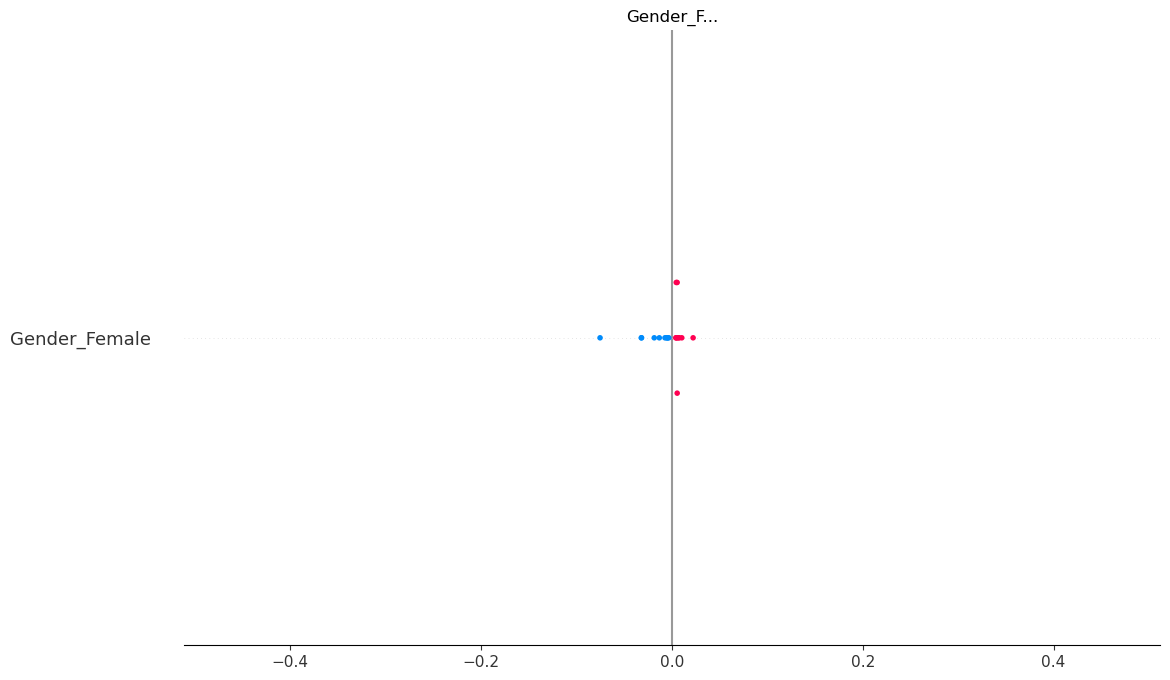

In [168]:
import shap
import pandas as pd

# Using a small sample from the training data for SHAP (to keep it fast)
X_sample = torch.tensor(X_test_np[:100], dtype=torch.float32)

# Define a prediction function for SHAP
def model_predict(data):
    model.eval()
    data_tensor = torch.tensor(data, dtype=torch.float32)
    with torch.no_grad():
        outputs = model(data_tensor).numpy()
    return outputs

# Use SHAP KernelExplainer
explainer = shap.KernelExplainer(model_predict, X_sample.numpy())

# Explain a few test samples
shap_values = explainer.shap_values(X_sample.numpy()[:20])

# Plot summary of feature importance
shap.summary_plot(shap_values, features=X_sample.numpy()[:20], feature_names=feature_names)
